In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
import nltk
import math
import pickle

import xgboost

from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model
from sklearn.linear_model import Perceptron

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, cross_val_predict

%matplotlib inline

In [2]:
# Load the data

df_ = pd.read_csv('protein-11-Functions-April9.csv')

df_.head()

/Users/scottlew/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,classification,name,sequence,structureId,type
0,TRANSFERASE,NaN,MEIYEGKLTAEGLRFGIVASRFNHALVDRLVEGAIDCIVRHGGREE...,5MPP,4
1,HYDROLASE,NaN,MKFTLTIAGLLAVGSTAAPTTEKRNPGGIDYVQNYNGDVADFQYNE...,3M4F,0
2,TRANSFERASE,NaN,MRGSHHHHHHGSMKRAVITGLGIVSSIGNNQQEVLASLREGRSGIT...,2BYY,4
3,HYDROLASE,NaN,STGSATTTPIDSLDDAYITPVQIGTPAQTLNLDFDTGSSDLWVFSS...,4YCY,0
4,TRANSFERASE,NaN,GSGMMRYLHKIELELNRLTSRYPFFKKIAFDAEIIKLVDDLNVDEN...,3AQC,4


## 11 Classes of Proteins

In [3]:
df_.classification.value_counts()

DNA BINDING            52997
TRANSPORT              38052
OXIDOREDUCTASE         37557
HYDROLASE              37436
TRANSFERASE            35880
LIGASE                 33967
IMMUNE SYSTEM          33433
GPCR                   31399
LIPID BINDING          31188
IRON-SULFUR-CLUSTER    31185
ISOMERASE              16988
Name: classification, dtype: int64

In [4]:
df_.type.value_counts()

12    52997
10    38052
5     37557
0     37436
4     35880
3     33967
1     33433
8     31399
9     31188
6     31185
2     16988
Name: type, dtype: int64

## Subset the data: use fewer rows of data for quicker comparison of XGBoost with other models

In [5]:
df_new= df_.sample(frac = 1.0)

df_new.shape

(380082, 5)

## Classifier of Protein Sequences: Predict 11 Classes

## CountVectorizer: Count peptide frequency, transform the data

In [6]:
# In this case, peptide frequency is used for analysis
peptide_size = 5
vect_ = CountVectorizer(min_df=1,token_pattern=r'\w{1}',ngram_range=(peptide_size,peptide_size))

## Split the data into training & test sets for classification model

In [7]:
X = vect_.fit_transform(df_new.sequence)
y = df_new.type

In [8]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state =42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

((304065, 3062983), (304065,))
((76017, 3062983), (76017,))


In [9]:
y_test.value_counts()

12    10609
10     7595
5      7588
0      7382
4      7275
3      6798
1      6633
8      6309
9      6245
6      6170
2      3413
Name: type, dtype: int64

## Classification Models

## Voting Models

In [10]:
%%time
clf1 = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
clf2 = PassiveAggressiveClassifier(C=0.1)

eclf1 = VotingClassifier(estimators=[('sgd',clf1), ('pac',clf2)], voting='hard')
eclf1.fit(X_train, y_train)
# evaluate accuracy of our model on test data
print("Majority Voting Classifier Score: {:.2f}".format(eclf1.score(X_test, y_test)))
print()

/Users/scottlew/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Majority Voting Classifier Score: 0.89
()
CPU times: user 5min 37s, sys: 3.58 s, total: 5min 41s
Wall time: 5min 37s


In [11]:
# Generate Confusion Matrix for Voting Model
actual = y_test
predictions = eclf1.predict(X_test)
print('Confusion Matrix for Voting Model')
print()
cm = confusion_matrix(actual,predictions)
print(cm)

Confusion Matrix for Voting Model
()
[[6384   87    9   70  250   85    0    1    3  173  320]
 [  79 6475    0    8   12    4    0    0    0   18   37]
 [ 153   10 3075   13   54   28    0    1    2   30   47]
 [ 271   19    3 5972   90   32    0    7    5  100  299]
 [ 545   40   11   73 5978  102    0    1   27  161  337]
 [ 266   22   10   26  135 6868    5    4    0  103  149]
 [   3    1    0    0    2    8 6149    0    0    5    2]
 [  46    1    0    8   11    6    0 6136    0   42   59]
 [  99    4    0    9   35   22    0    0 5943   89   44]
 [ 456   63    3   86  154   87    0   36   79 6059  572]
 [ 424  100   47  259  295  135    0  143    7  524 8675]]


In [12]:
vote_prediction1 = eclf1.predict(X_test)
print(classification_report(vote_prediction1, y_test))

              precision    recall  f1-score   support

           0       0.86      0.73      0.79      8726
           1       0.98      0.95      0.96      6822
           2       0.90      0.97      0.94      3158
           3       0.88      0.92      0.90      6524
           4       0.82      0.85      0.84      7016
           5       0.91      0.93      0.92      7377
           6       1.00      1.00      1.00      6154
           8       0.97      0.97      0.97      6329
           9       0.95      0.98      0.97      6066
          10       0.80      0.83      0.81      7304
          12       0.82      0.82      0.82     10541

   micro avg       0.89      0.89      0.89     76017
   macro avg       0.90      0.90      0.90     76017
weighted avg       0.89      0.89      0.89     76017



In [13]:
%%time
clf1a = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
clf2a = PassiveAggressiveClassifier(C=0.1)
clf3a = MultinomialNB(alpha=50)

eclf2 = VotingClassifier(estimators=[('sgd', clf1a), ('pac', clf2a), ('mnb', clf3a)], voting='hard')
eclf2.fit(X_train, y_train)
# evaluate accuracy of our model on test data
print("Majority Voting Classifier Score: {:.2f}".format(eclf2.score(X_test, y_test)))
print()

Majority Voting Classifier Score: 0.89
()
CPU times: user 6min 4s, sys: 6.37 s, total: 6min 10s
Wall time: 6min 5s


In [14]:
# Generate Confusion Matrix for Voting Model
actual = y_test
predictions = eclf2.predict(X_test)
print('Confusion Matrix for Voting Model')
print()
cm = confusion_matrix(actual,predictions)
print(cm)

Confusion Matrix for Voting Model
()
[[6189   38    8   93  256   76    0    1    4  175  542]
 [  71 6394    0   10   12    1    0    0    0   10  135]
 [ 139    3 3021   30   50   24    0    1    1   24  120]
 [ 170    9    3 5942   84   23    0    8    5   71  483]
 [ 437   21    8  139 5837   74    0    3   27  166  563]
 [ 231   14    8   88   99 6787    5    7    0   86  263]
 [   1    0    0    1    2    5 6140    0    0    5   16]
 [   6    0    0    3    3    2    0 6185    0   48   62]
 [  76    4    0   11   27   19    0    3 5916   83  106]
 [ 378   43    2  124  109   62    3   50   72 5843  909]
 [ 300   56   33  207  211   97    0  139   11  364 9191]]


In [15]:
vote_prediction2 = eclf2.predict(X_test)
print(classification_report(vote_prediction2, y_test))

              precision    recall  f1-score   support

           0       0.84      0.77      0.80      7998
           1       0.96      0.97      0.97      6582
           2       0.89      0.98      0.93      3083
           3       0.87      0.89      0.88      6648
           4       0.80      0.87      0.84      6690
           5       0.89      0.95      0.92      7170
           6       1.00      1.00      1.00      6148
           8       0.98      0.97      0.97      6397
           9       0.95      0.98      0.96      6036
          10       0.77      0.85      0.81      6875
          12       0.87      0.74      0.80     12390

   micro avg       0.89      0.89      0.89     76017
   macro avg       0.89      0.91      0.90     76017
weighted avg       0.89      0.89      0.89     76017



In [16]:
#######################################################################################

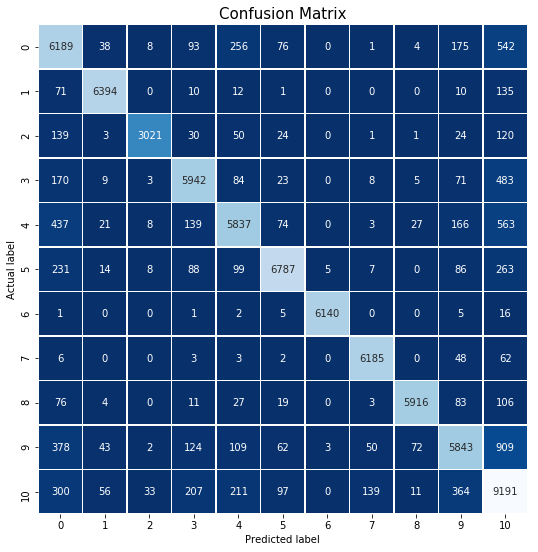

In [17]:
# Confusion matrix made pretty for Capstone report

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r',cbar=None);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

plt.title('Confusion Matrix', size = 15)
plt.savefig('ConfusionMatrix_VotingClassifier_Functions_1.png')